# 🛒 Shopper Spectrum: Customer Segmentation & Product Recommendations in E-Commerce

## 📥 Load and Understand Dataset

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = 'Online Retail.xlsx'

try:
    df = pd.read_excel(file_path)
except Exception as e:
    print("Error loading file:", e)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 🧹 Data Cleaning & Preprocessing

In [21]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.reset_index(drop=True, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## 📊 Exploratory Data Analysis (EDA)

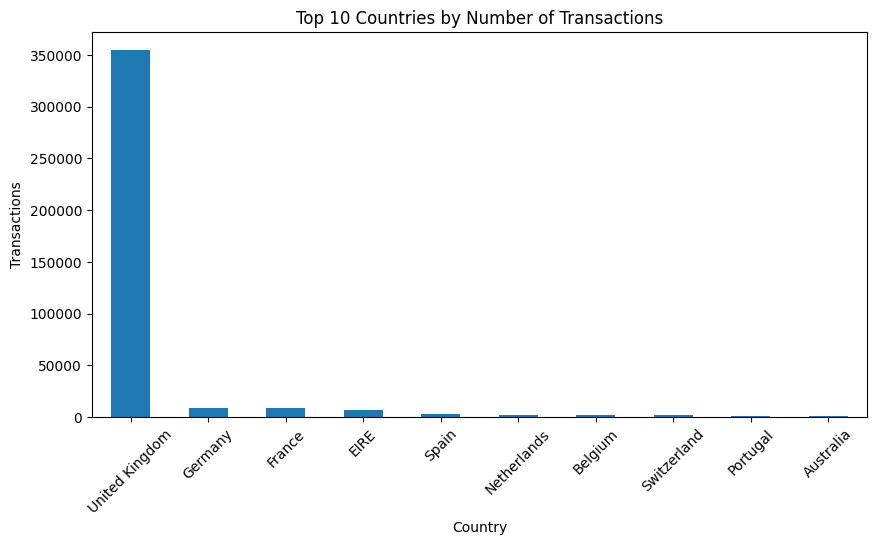

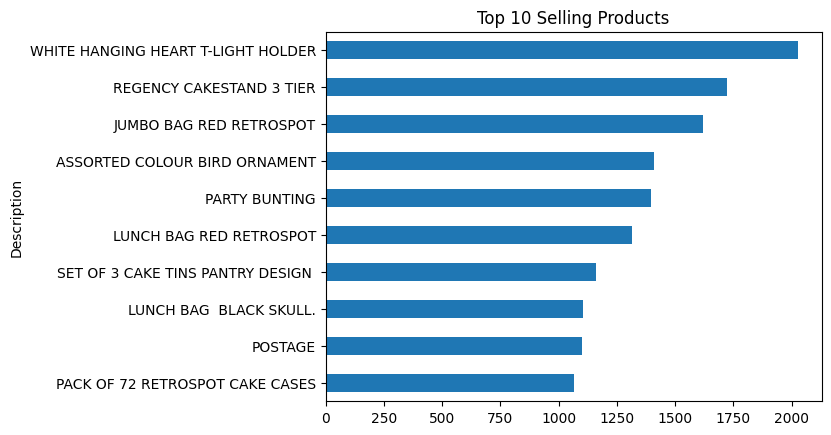

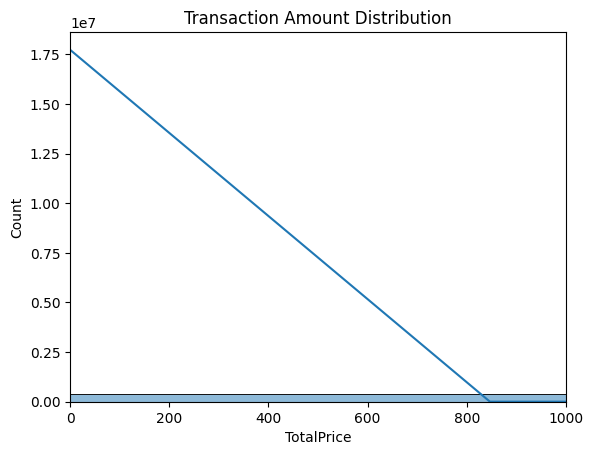

In [22]:
plt.figure(figsize=(10,5))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries by Number of Transactions')
plt.ylabel('Transactions')
plt.xticks(rotation=45)
plt.show()

top_products = df['Description'].value_counts().head(10)
top_products.plot(kind='barh', title='Top 10 Selling Products')
plt.gca().invert_yaxis()
plt.show()

sns.histplot(df['TotalPrice'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlim(0, 1000)
plt.show()

## 🎯 RFM Feature Engineering (Recency, Frequency, Monetary)

In [23]:
import datetime as dt
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## 🔄 KMeans Clustering for Customer Segmentation

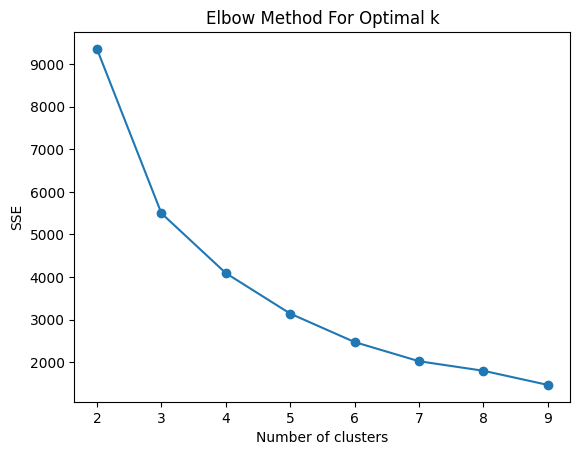

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,3
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Elbow method
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 10), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()

## 🧠 Product Recommendation System (Collaborative Filtering)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

pivot = df.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc='sum').fillna(0)
similarity = cosine_similarity(pivot.T)
sim_df = pd.DataFrame(similarity, index=pivot.columns, columns=pivot.columns)

def get_recommendations(product_name, top_n=5):
    if product_name not in sim_df.columns:
        return []
    return sim_df[product_name].sort_values(ascending=False).iloc[1:top_n+1].index.tolist()

get_recommendations('WHITE HANGING HEART T-LIGHT HOLDER')

['GIN + TONIC DIET METAL SIGN',
 'RED HANGING HEART T-LIGHT HOLDER',
 'WASHROOM METAL SIGN',
 'LAUNDRY 15C METAL SIGN',
 'GREEN VINTAGE SPOT BEAKER']

## 💾 Save Clustering and Scaler Models (for Streamlit)

In [26]:
import joblib

joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
sim_df.to_pickle('similarity_matrix.pkl')

REQUIRED FILES

In [27]:
!pip install streamlit pyngrok --quiet


APP.PY

In [28]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# Load saved models
kmeans = joblib.load("kmeans_model.pkl")
scaler = joblib.load("scaler.pkl")
similarity_matrix = pd.read_pickle("similarity_matrix.pkl")

# Streamlit app
st.set_page_config(page_title="Shopper Spectrum", layout="wide")

st.title("🛍️ Shopper Spectrum Dashboard")

tab1, tab2 = st.tabs(["📦 Product Recommender", "👥 Customer Segmentation"])

with tab1:
    st.header("🔍 Product Recommendation")
    product_name = st.text_input("Enter Product Name (exact match):")
    if product_name:
        if product_name in similarity_matrix.index:
            sim_scores = similarity_matrix[product_name].sort_values(ascending=False)[1:6]
            st.success("Top 5 Similar Products:")
            for item in sim_scores.index:
                st.write(f"• {item}")
        else:
            st.error("❌ Product not found. Please check the name.")

with tab2:
    st.header("📊 Customer Segmentation")
    r = st.number_input("Recency (days)", min_value=1)
    f = st.number_input("Frequency (number of purchases)", min_value=1)
    m = st.number_input("Monetary (total spend)", min_value=1)

    if st.button("Predict Segment"):
        input_data = scaler.transform([[r, f, m]])
        cluster = kmeans.predict(input_data)[0]
        segments = {0: "High-Value", 1: "Regular", 2: "Occasional", 3: "At-Risk"}
        st.info(f"Predicted Segment: **{segments.get(cluster, 'Unknown')}**")


Overwriting app.py


🚀 Streamlit App Deployment with Ngrok

In [31]:
from pyngrok import conf, ngrok
import os

conf.get_default().auth_token = "2zYIVJJ00RFBvctZceJ1HQWH7aC_3oHYV9vccig8UUwytLzuw"

!pkill streamlit

get_ipython().system('streamlit run app.py &>/content/log.txt &')

public_url = ngrok.connect("http://localhost:8501")
print(f"✅ Streamlit dashboard is live at: {public_url}")


✅ Streamlit dashboard is live at: NgrokTunnel: "https://587cba59e2fa.ngrok-free.app" -> "http://localhost:8501"
